In [1]:
!pip install tensorflow
!pip install keras scikit_learn

# **Sales Revenue and Volume Forecasting Model**

## **Sales Revenue and Volume Forecasting model overview**


*   The  model uses online Retail Data from UC Irvine Machine Learning Repository
Online Retail - UCI Machine Learning Repository
*  Link to the data source https://archive.ics.uci.edu/dataset/352/online+retail

*   This data set contains all 541909 transactions between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online global retail company.
*   In this model we used LSTM models (Long Short Term Memory) to develop forecasting for sales revenue and sales volume
*   We used hyperparamter tuning to find the optimal LSTM models that produced the forecast with the least RMSE
*   The model takes around 30 minutes to run, primarily to search for optimal parameters for LSTM




The following cell consists of all the imported libraries for this model

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

filterwarnings('ignore')



**Setting the random seed**

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## **Loading the data**

**This cell of the code is only applicable if you are using Colabs and Google Drive**

If you are not using Google Drive to load the data then comment the code in this cell.
If you are using Goolge Drive to load the data then "update" the drive location to the folder name where you have the data saved



In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SalesForecastingProject

Mounted at /content/drive
/content/drive/MyDrive/SalesForecastingProject


**File path for the data file**

Please update the filepath for the OnlineRetail data file

In [5]:
filepath="data/OnlineRetail.xlsx"

**Loading and initial profiling of the data**

In [6]:
online_retail_data = pd.read_excel(filepath)
online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## **Online retail data quality is adequate for analyis**
* 25% of customer ID is null, but that does not impact analysis as we are looking at daily sales revenue and volume
* Less than 1% of description is null

In [8]:
null_counts = online_retail_data.isna().sum()
print(null_counts)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## **Feature Engineering of data**


*   Convert the InvoiceDate timestamp to a datetime object
*   Create "FullDate" feature that only has the data
*   Create "Year" feature that only has the year for the Invoice
*   Create "Month" feature that only has the month for the Invoice
*   Create "YearMonth" feature that has the Year and Month for the Invoice
*   Create "DayOfWeek" feature that has the Day of the week for the Invoice
*   Create "SalesDollars" feature that is unit price of the item multiplied by the quantity










In [9]:
online_retail_data['InvoiceDate'] = pd.to_datetime(online_retail_data['InvoiceDate'])

In [10]:
online_retail_data['FullDate'] = online_retail_data['InvoiceDate'].dt.date
online_retail_data['Year'] = online_retail_data['InvoiceDate'].dt.year
online_retail_data['Month'] = online_retail_data['InvoiceDate'].dt.month
online_retail_data['YearMonth'] = online_retail_data['InvoiceDate'].dt.strftime('%Y-%m')
online_retail_data['DayOfWeek'] = online_retail_data['InvoiceDate'].dt.day_name()

In [11]:
online_retail_data['SalesDollars'] = online_retail_data['Quantity'] * online_retail_data['UnitPrice']

In [12]:
online_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FullDate,Year,Month,YearMonth,DayOfWeek,SalesDollars
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,2010-12,Wednesday,20.34


In [13]:
online_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     541909 non-null  object        
 1   StockCode     541909 non-null  object        
 2   Description   540455 non-null  object        
 3   Quantity      541909 non-null  int64         
 4   InvoiceDate   541909 non-null  datetime64[ns]
 5   UnitPrice     541909 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       541909 non-null  object        
 8   FullDate      541909 non-null  object        
 9   Year          541909 non-null  int32         
 10  Month         541909 non-null  int32         
 11  YearMonth     541909 non-null  object        
 12  DayOfWeek     541909 non-null  object        
 13  SalesDollars  541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(7)
memo

## **Data profling and visualization**

## **Time series profiling of sales volume versus date**

**Key findings**


*   Total Sales Volume is **5.17M**
*   Overall trend of sales volume has a positive trajectory over time - especially over the last 150 days
*   Sales volume has seasonality, there is strong seasonality every 30 days, some seasonality every 90 days, and weak to no seasonality on a weekly basis


**Approach**

*   Grouped the data by quantity and date (full date)
*   Visualized the variation of sales volume with date
*   Decomposed time series data to extract trend, seasonality and noise
*   To interpret seasonality, generated ACF plots with 7, 30 and 90 day lages





In [14]:
salesquantity_by_date = online_retail_data.groupby(['FullDate'])['Quantity'].sum().reset_index()

In [15]:
total_quantity = salesquantity_by_date['Quantity'].sum()
print(f"Total Quantity: {total_quantity}")

Total Quantity: 5176450


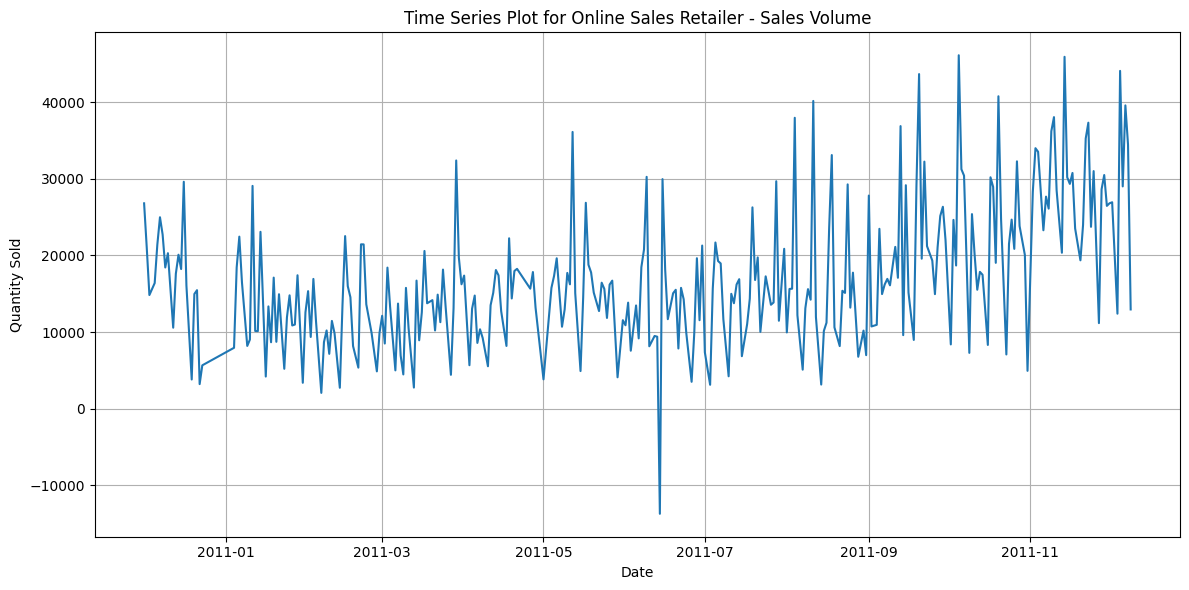

In [16]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(salesquantity_by_date['FullDate'], salesquantity_by_date['Quantity'])
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Time Series Plot for Online Sales Retailer - Sales Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
decomposition_quantity = seasonal_decompose(salesquantity_by_date['Quantity'], model='additive', period=30)  # Adjust period if needed

# Access the components
trend_quantity = decomposition_quantity.trend
seasonal_quantity = decomposition_quantity.seasonal
residual_quantity = decomposition_quantity.resid


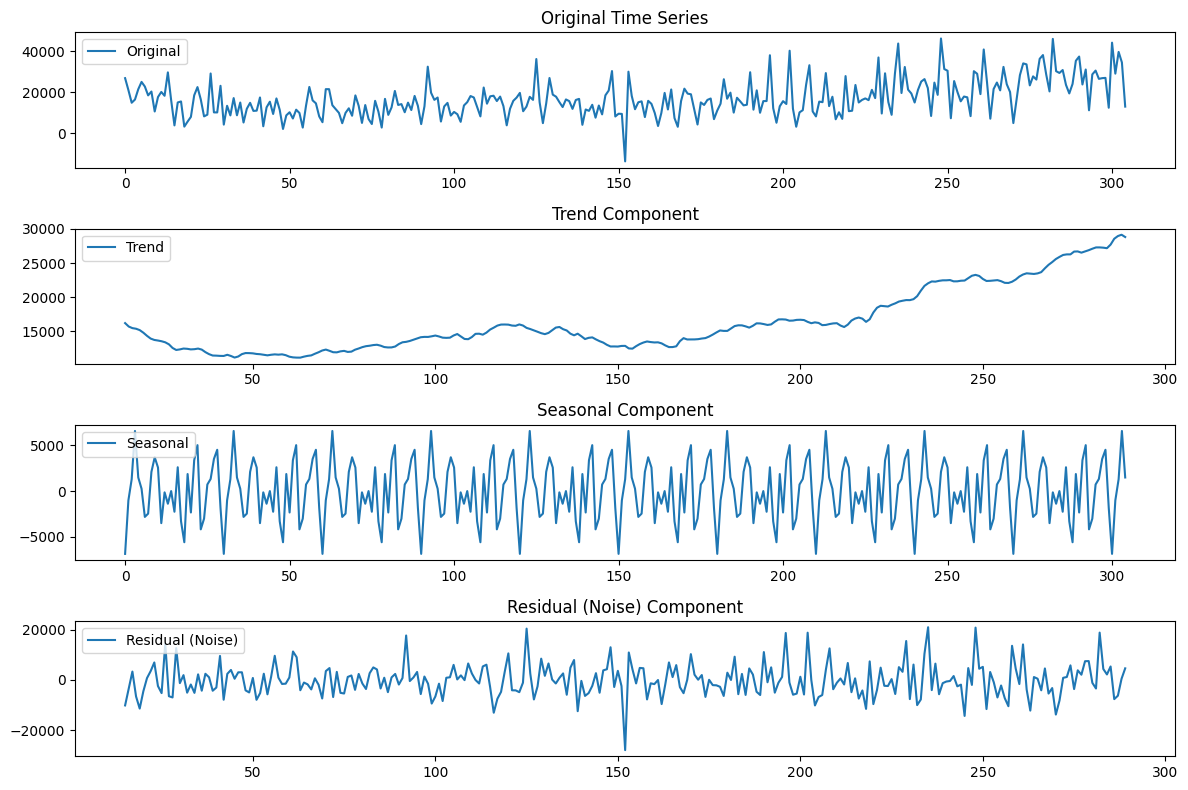

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(salesquantity_by_date['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend_quantity, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal_quantity, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual_quantity, label='Residual (Noise)')
plt.legend(loc='upper left')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

### **ACF Plots for Seasonality of Sales Volume**

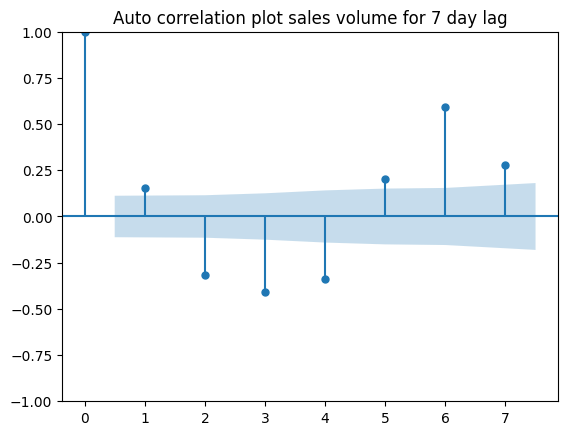

In [19]:
plot_acf(seasonal_quantity, lags=7)  # Adjust lags as needed
plt.title(f'Auto correlation plot sales volume for 7 day lag')
plt.show()

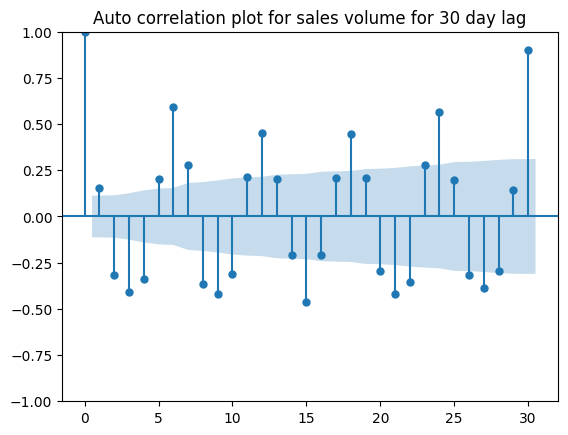

In [20]:
  plot_acf(seasonal_quantity, lags=30)  # Adjust lags as needed
  plt.title(f'Auto correlation plot for sales volume for 30 day lag')
  plt.show()

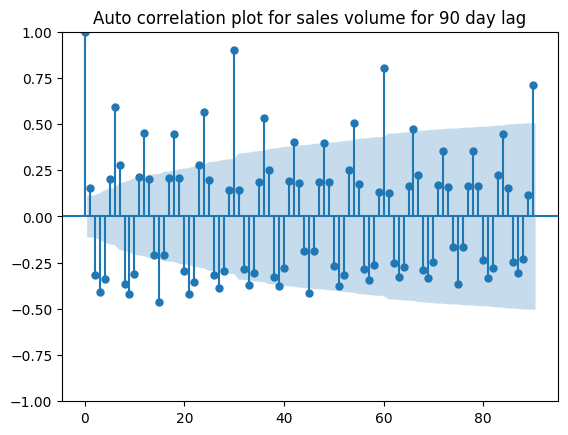

In [21]:
plot_acf(seasonal_quantity, lags=90)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales volume for 90 day lag')
plt.show()

## **Time series profiling of sales revenues versus date**

**Key findings**

*   Total sales revenue is **$9.74M**
*   Overall trend of sales revenues has a positive trajectory over time - especially over the last 100 days
*   Sales revenues has seasonality, there is strong seasonality every 30 days, some seasonality every 90 days (weakens after 30 days), and weak to no seasonality on a weekly basis


**Approach**

*   Grouped the data by sales revenues and date (full date)
*   Visualized the variation of sales revenues with date
*   Decomposed time series data to extract trend, seasonality and noise
*   To interpret seasonality, generated ACF plots with 7, 30 and 90 day lages

In [22]:
salesdollars_by_date = online_retail_data.groupby(['FullDate'])['SalesDollars'].sum().reset_index()

In [23]:
total_sales = salesdollars_by_date['SalesDollars'].sum()
print(f"Total Revenues: {total_sales}")

Total Revenues: 9747747.934


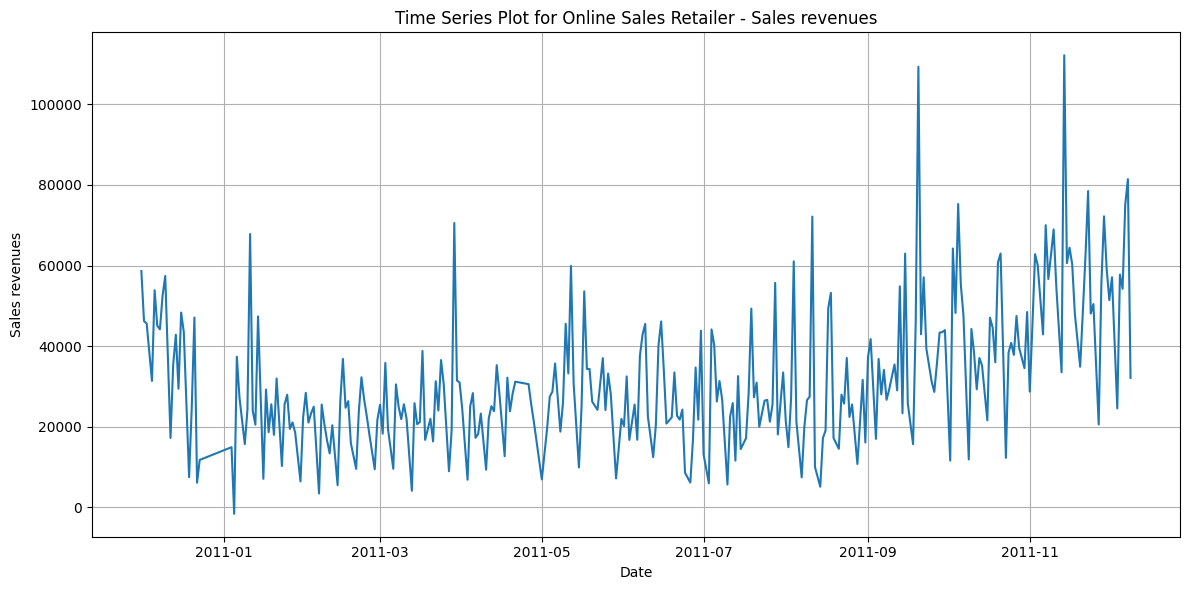

In [24]:
# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(salesdollars_by_date['FullDate'], salesdollars_by_date['SalesDollars'])
plt.xlabel('Date')
plt.ylabel('Sales revenues')
plt.title(f'Time Series Plot for Online Sales Retailer - Sales revenues')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Decompose the time series
decomposition_sales = seasonal_decompose(salesdollars_by_date['SalesDollars'], model='additive', period=30)  # Adjust period if needed

# Access the components
trend_sales = decomposition_sales.trend
seasonal_sales = decomposition_sales.seasonal
residual_sales = decomposition_sales.resid


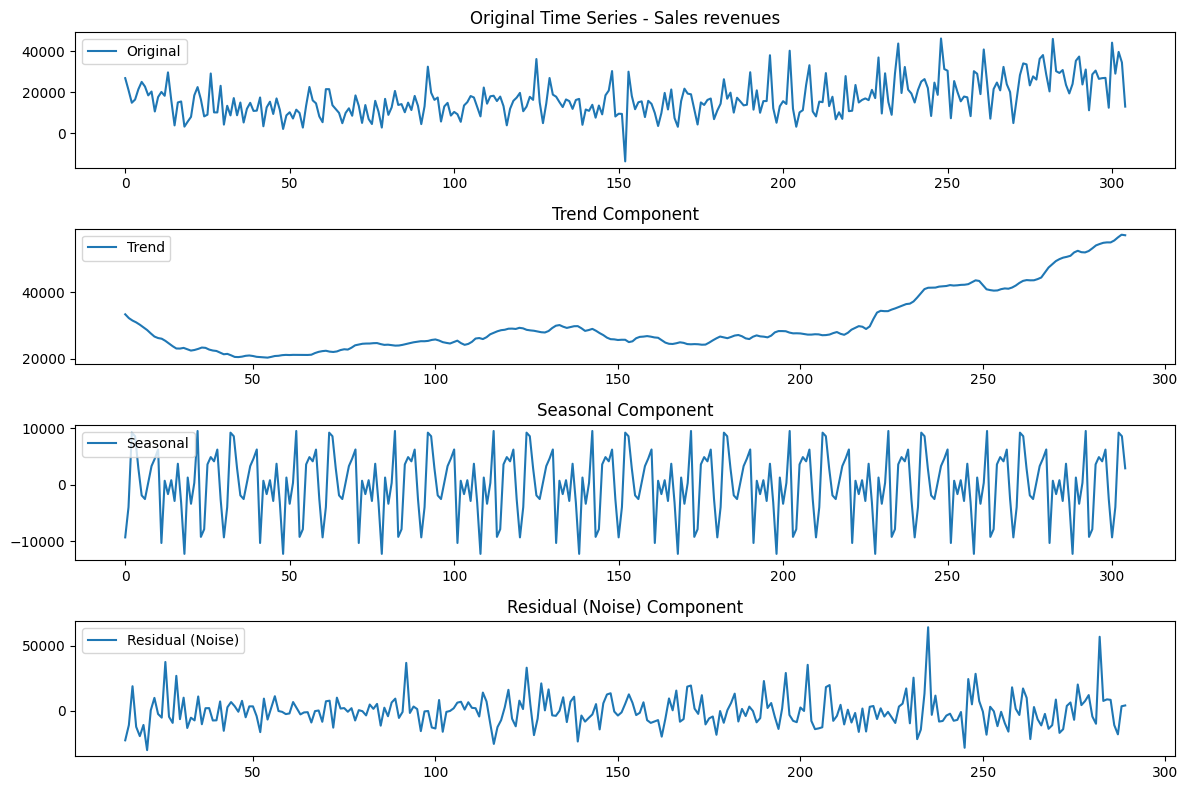

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(salesquantity_by_date['Quantity'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series - Sales revenues')

plt.subplot(412)
plt.plot(trend_sales, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal_sales, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual_sales, label='Residual (Noise)')
plt.legend(loc='upper left')
plt.title('Residual (Noise) Component')

plt.tight_layout()
plt.show()

### **ACF Plots for Seasonality of Sales Revenues**

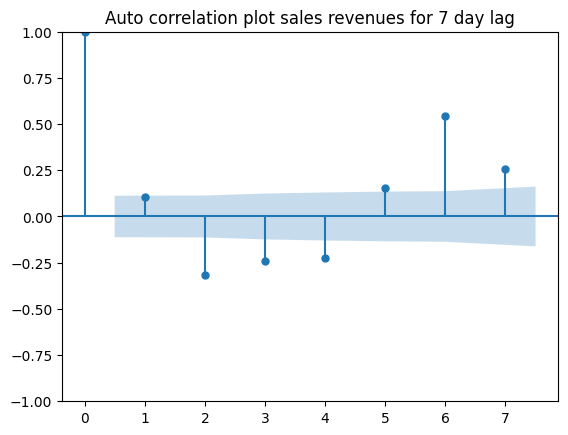

In [27]:
plot_acf(seasonal_sales, lags=7)  # Adjust lags as needed
plt.title(f'Auto correlation plot sales revenues for 7 day lag')
plt.show()

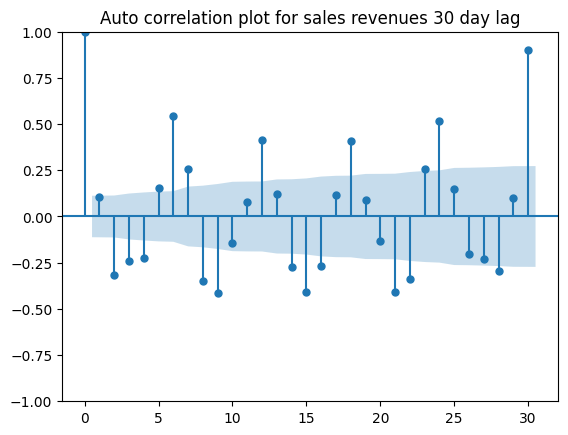

In [28]:
plot_acf(seasonal_sales, lags=30)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales revenues 30 day lag')
plt.show()

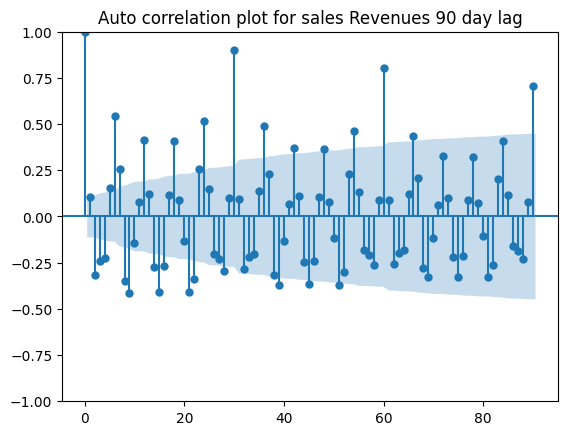

In [29]:
plot_acf(seasonal_sales, lags=90)  # Adjust lags as needed
plt.title(f'Auto correlation plot for sales Revenues 90 day lag')
plt.show()

## **Visualization of other data elements in online sales**






### **Distribution of sales by country - most of sales are in UK**

In [30]:
country_sales = online_retail_data.groupby('Country')['Quantity'].sum().reset_index()
country_sales = country_sales.sort_values(by=['Quantity'], ascending=False)


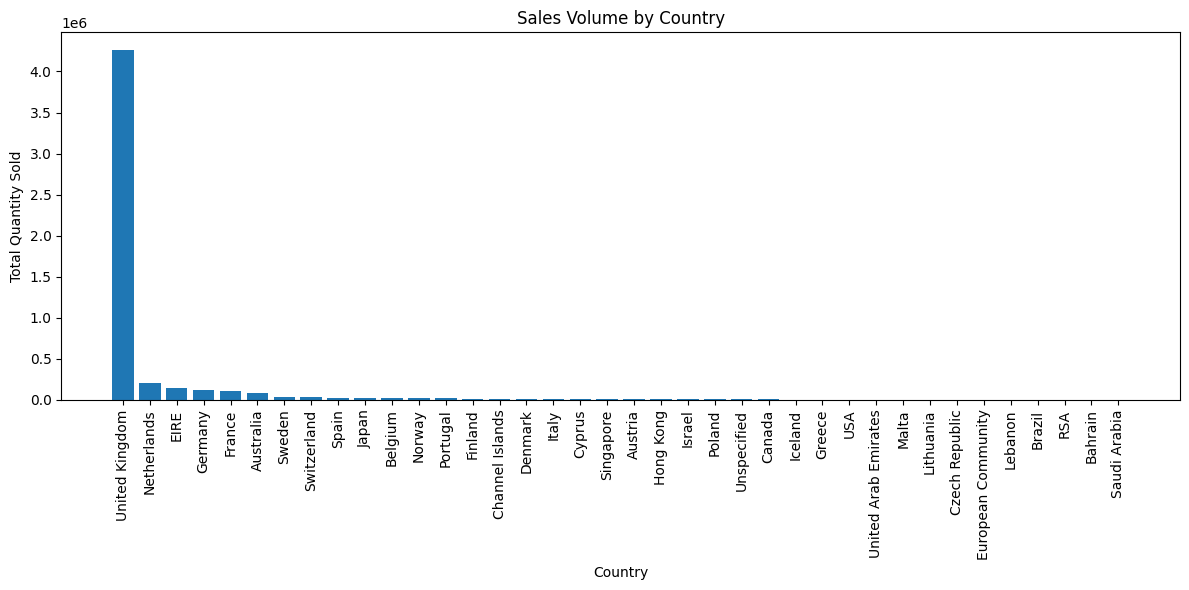

In [31]:
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(country_sales['Country'], country_sales['Quantity'])
plt.xlabel('Country')
plt.ylabel('Total Quantity Sold')
plt.title('Sales Volume by Country')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### **SKU profile on online retaier**
* 4070 SKU sold
* Top 100 SKUs represent ~30% of sold volume

In [32]:
unique_stockcodes_count = online_retail_data['StockCode'].nunique()
print(f"Number of unique StockCodes: {unique_stockcodes_count}")

Number of unique StockCodes: 4070


In [33]:
stockcode_quantity = online_retail_data.groupby('StockCode')['Quantity'].sum().reset_index()
stockcode_quantity_sorted = stockcode_quantity.sort_values(by=['Quantity'], ascending=False)
total_quantity = stockcode_quantity_sorted['Quantity'].sum()
stockcode_quantity_sorted['Percentage'] = (stockcode_quantity_sorted['Quantity'] / total_quantity) * 100
print(stockcode_quantity_sorted.head(10))

     StockCode  Quantity  Percentage
1070     22197     56450    1.090516
2622     84077     53847    1.040230
3659    85099B     47363    0.914971
3670    85123A     38830    0.750128
2735     84879     36221    0.699727
377      21212     36039    0.696211
1905     23084     30646    0.592027
1335     22492     26437    0.510717
1453     22616     26315    0.508360
889      21977     24753    0.478185


In [34]:
top_100_skus = stockcode_quantity_sorted.head(100)
top_100_percentage_sum = top_100_skus['Percentage'].sum()
print(f"Sum of percentage quantity for top 100 SKUs: {top_100_percentage_sum}")


Sum of percentage quantity for top 100 SKUs: 29.782804817973712


In [35]:
yearly_sales = online_retail_data.groupby('Year')['Quantity'].sum().reset_index()
yearly_sales = yearly_sales.sort_values(by=['Year'], ascending=True)
yearly_sales

,Year,Quantity
0,2010,342228
1,2011,4834222


In [36]:
year_month_sales = online_retail_data.groupby('YearMonth')['Quantity'].sum().reset_index()
year_month_sales = year_month_sales.sort_values(by=['YearMonth'], ascending=True)

### **Monthly sales - sales are showing are an updward trajectory except in Dec 2012**

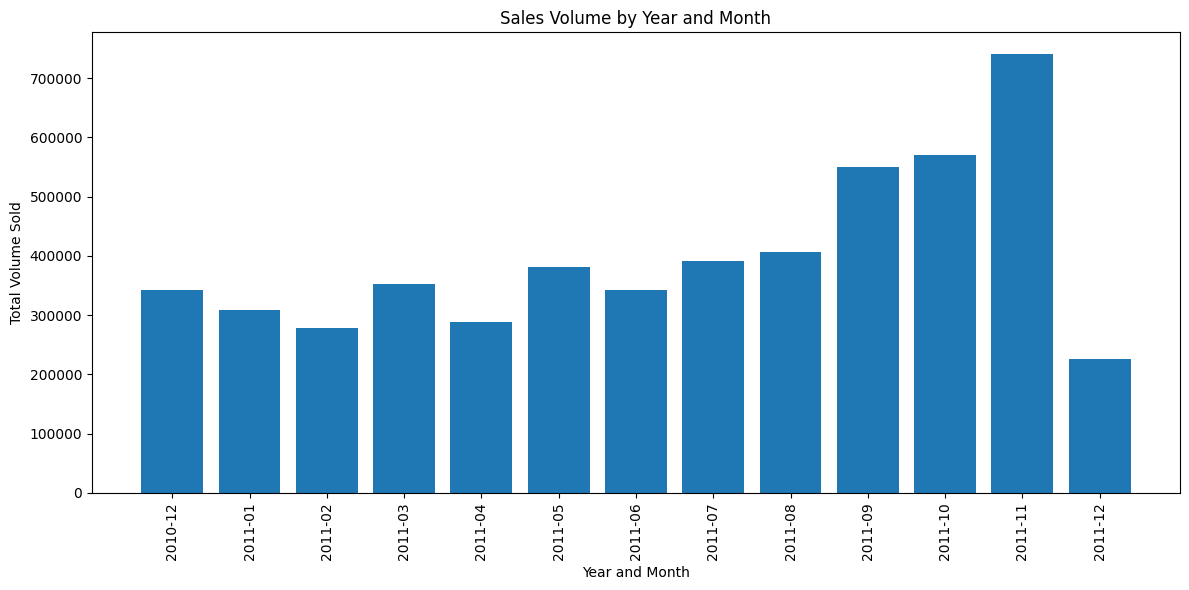

In [37]:
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(year_month_sales ['YearMonth'], year_month_sales ['Quantity'])
plt.xlabel('Year and Month')
plt.ylabel('Total Volume Sold')
plt.title('Sales Volume by Year and Month')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [38]:
#LSTM Forecasting model for SalesDollars

# **LSTM Model Foecasting**

In [39]:
#setting up the data for LSTM models
def set_up_data(data, look_back):
  X, y = [], []
  for i in range(look_back, len(data)):
    X.append(data[i - look_back:i, 0])
    y.append(data[i, 0])

  X, y = np.array(X), np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series
  # Reshape for LSTM input (samples, timesteps, features)
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  return X_train, X_test, y_train, y_test

## **Sales Revenues Forecasting**




### **Creating LSTM Model with standard parameters**


*   Create a dataframe Daily Sales that calculates sales revenues by date
*   Used MinMax Scaler to scale the data
*   Created lagged features - using a look back period of 7 days


*   Split the data into training and test set
*   Used a sequential model using the Keras library, specifically designed for time series forecasting or sequence prediction tasks using Long Short-Term Memory (LSTM) networks.


*   The first layer of the model has 32 units (memory cells)
*   The first layer outputs the full sequence of hidden states to the next LSTM layer


*   The model has a second layer of 32 units
*   The model has a dense layer as the output with a single neuron - output is a single value - next sales volume


*   The model is trained with the training set data with batch size of 32 - weights would be updated after processing 32 samples
*   











In [40]:
daily_sales = online_retail_data.groupby('FullDate')['SalesDollars'].sum().reset_index()
daily_sales = daily_sales.set_index('FullDate') # Set 'FullDate' as index

In [41]:
# Assuming daily_sales is your DataFrame with 'FullDate' as index and 'SalesDollars' as the column
sales_data = daily_sales['SalesDollars'].values.reshape(-1, 1)  # Reshape for scaling


In [42]:
# Scale the data
scaler = MinMaxScaler()
sales_data = scaler.fit_transform(sales_data)

In [43]:
 X_train, X_test, y_train, y_test=set_up_data(sales_data,7)

In [44]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
model.add(LSTM(units=32))  # You can add more LSTM layers
model.add(Dense(1))

In [45]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [46]:
np.random.seed(42)
tf.random.set_seed(42)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)  # Adjust epochs and batch size

### **Predictions of Sales Revenues using LSTM Model**


*   After training the model, predict sales revenues using predict function
*   Inverse transform the test data and the prediction values to get actual sales revenues in test and predicted data set


*   Plot the results
*   Calculate the RMSE using the test and predicted values





In [47]:
predictions = model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])  # Reshape y_test for inverse transform

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [48]:
# Assuming 'daily_sales' has a 'FullDate' index
test_dates = daily_sales.index[-len(y_test[0]):]  # Get dates for the test set


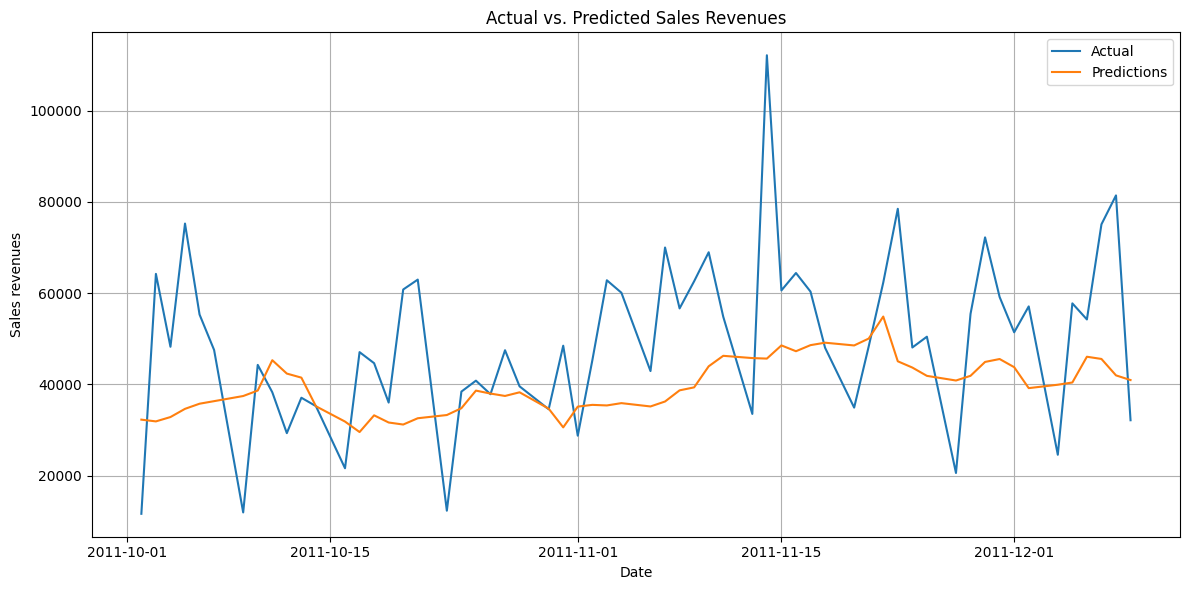

In [49]:
# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales revenues')
plt.title('Actual vs. Predicted Sales Revenues')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE: {rmse}')

RMSE: 19951.82461708219


### **Hyperparmater tuning to find optimal LSTM Model for Sales Revenues forecasting**


*   Used the following hyperparmeters to find the optimal model with lowest RMSE

    *   Look back period - 7, 30, 90 days
    *   Number of units in model - 32,64,128,258
    *   Batch sizes - 16,32,64


*   Used nested for loops to  different models with different hyper parameters
*   After training each model, generated predictions based on test data


*   For each model calcualted the RMSE using prediction and test data
*   Captured the parameters for the model with the lowest RMSE as the "optimal model"








In [51]:
# Define a range of hyperparameters to search
units = [32, 64, 128, 256]
look_backs = [7, 30, 90]
batch_sizes = [16, 32, 64]

best_rmse = float('inf')
best_params = {}

In [52]:
# Loop through hyperparameter combinations
np.random.seed(42)
tf.random.set_seed(42)
for look_back in look_backs:
  X, y = [], []
  for i in range(look_back, len(sales_data)):
    X.append(sales_data[i - look_back:i, 0])
    y.append(sales_data[i, 0])
  X, y = np.array(X), np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  y_test = scaler.inverse_transform([y_test])
  y_test = y_test.reshape(-1, 1)
  for unit in units:
    for batch_size in batch_sizes:
      model = Sequential()
      model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
      model.add(LSTM(units=unit))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')
      early_stopping = EarlyStopping(monitor='val_loss', patience=10)
      y_train = y_train.reshape(-1, 1)
      model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      predictions = model.predict(X_test)

      predictions = scaler.inverse_transform(predictions)
      rmse = np.sqrt(mean_squared_error(y_test, predictions))
      if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'units': unit, 'look_back': look_back, 'batch_size': batch_size}
        print(f'New best RMSE: {best_rmse} with params: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Parameters: {best_params}')




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
New best RMSE: 23047.86501620044 with params: {'units': 32, 'look_back': 7, 'batch_size': 16}


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
New best RMSE: 21714.585294107263 with params: {'units': 32, 'look_back': 7, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
New best RMSE: 20454.169615109055 with params: {'units': 256, 'look_back': 7, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
New best RMSE: 19894.58865945

### **LSTM Model with optimal hyperparameters for Sales Revenue Forecasting**


*   Using the optimal hyper parameters trained the model - 30 day look back, 128 units, batch size of 64
*   Generated predictions and calculate RMSE, forecasting accuracy - **63.5%**


*   Plotted the test data and predicted sales revenues





In [53]:
#Optimal Model LSTM Model
optimal_look_back = best_params['look_back']
optimal_units = best_params['units']
optimal_batch_size = best_params['batch_size']
print("The optimal LSTM Model for Sales Forecast")
print(f'Optimal look_back: {optimal_look_back}')
print(f'Optimal units: {optimal_units}')
print(f'Optimal batch_size: {optimal_batch_size}')

The optimal LSTM Model for Sales Forecast
Optimal look_back: 30
Optimal units: 128
Optimal batch_size: 64


In [54]:
sales_data = daily_sales['SalesDollars'].values.reshape(-1, 1)  # Reshape for scaling
# Scale the data
scaler = MinMaxScaler()
sales_data = scaler.fit_transform(sales_data)

In [55]:
X_train, X_test, y_train, y_test=set_up_data(sales_data, optimal_look_back)

In [56]:
optimal_model = Sequential()
optimal_model.add(LSTM(units=optimal_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
optimal_model.add(LSTM(units=optimal_units))  # You can add more LSTM layers
optimal_model.add(Dense(1))

In [57]:
optimal_model.compile(loss='mean_squared_error', optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
y_train = y_train.reshape(-1, 1)

In [58]:
np.random.seed(42)
tf.random.set_seed(42)
optimal_model.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size,callbacks=[early_stopping], verbose=0)  # Adjust epochs and batch size

In [59]:
predictions = optimal_model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [60]:
optimal_rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE for LSTM model with optimal hyperparameters is  {optimal_rmse}')

RMSE for LSTM model with optimal hyperparameters is  17948.357913457792


In [61]:
sales_dollar_mean = y_test[0].mean()
print(f'Mean value of sales revenues in test data is {sales_dollar_mean}')
forecasting_sales_error= optimal_rmse/sales_dollar_mean
print(f'Forecasting sales error {forecasting_sales_error}')
forecasting_sales_accuracy = 1-forecasting_sales_error
print(f'Forecasting sales revenue accuracy for LSTM model with optimal hyperparameters {forecasting_sales_accuracy}')

Mean value of sales revenues in test data is 49299.98218181817
Forecasting sales error 0.3640641866210886
Forecasting sales revenue accuracy for LSTM model with optimal hyperparameters 0.6359358133789115


In [62]:
test_dates = daily_sales.index[-len(y_test[0]):]

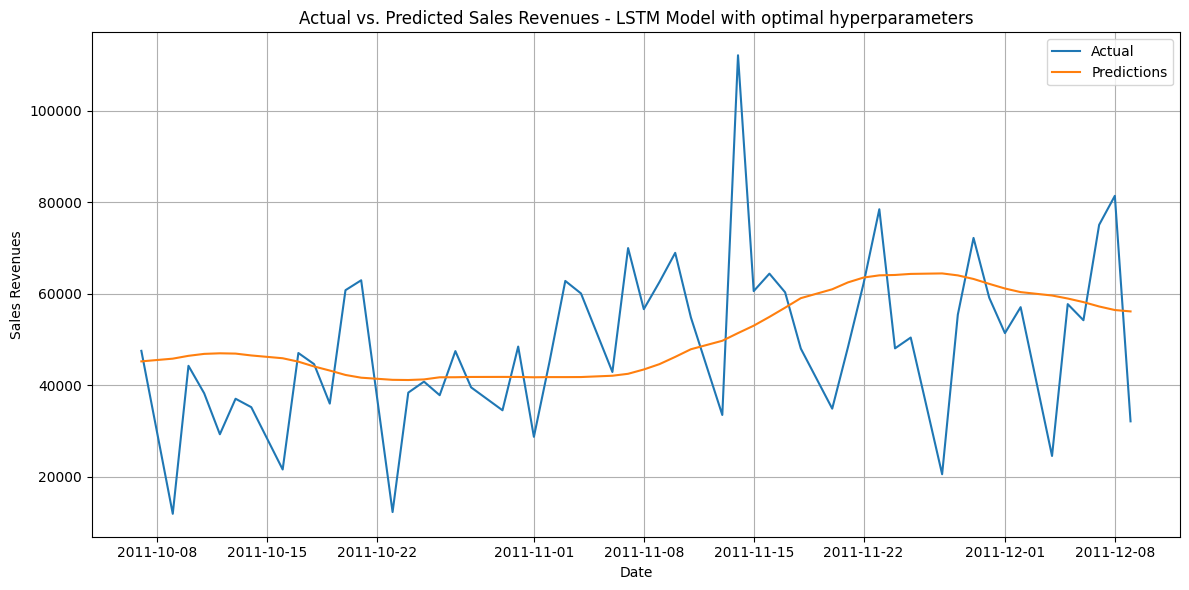

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Revenues')
plt.title('Actual vs. Predicted Sales Revenues - LSTM Model with optimal hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Improving LSTM model for Sales Revenues forecasting**
*  Adding layers did not improve forecast accuracy
*  Creaing bidirectional LSTM model with optimal hyperparameters did not improve forecast accuracy
*  Adding features to the LSTM model did not improve forecast accuracy

### **Adding layers to the model**
* Adding additional layers to the model increased RMSE

In [64]:
sales_data = daily_sales['SalesDollars'].values.reshape(-1, 1)  # Reshape for scaling
# Scale the data
scaler = MinMaxScaler()
sales_data = scaler.fit_transform(sales_data)

In [65]:
def create_model(num_layers):
    model = Sequential()
    model.add(LSTM(units=optimal_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for _ in range(num_layers - 1):
        model.add(LSTM(units=optimal_units, return_sequences=True))
    model.add(LSTM(units=optimal_units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model




In [66]:
# Grid Search Example
num_layers_to_try = [1, 2, 3, 4]
best_rmse = float('inf')
best_num_layers = 0

In [67]:
np.random.seed(42)
tf.random.set_seed(42)
for num_layers in num_layers_to_try:

    model = create_model(num_layers)
    X_train, X_test, y_train, y_test=set_up_data(sales_data, optimal_look_back)
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)

    # Inverse transform to get actual sales values
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform([y_test])
    val_rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
    print(f'RMSE for LSTM model with {num_layers} layers is  {val_rmse}')
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_num_layers = num_layers

print("Best number of layers:", best_num_layers)
print("Best RMSE:", best_rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
RMSE for LSTM model with 1 layers is  18322.51903689787
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
RMSE for LSTM model with 2 layers is  18947.46720050297
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
RMSE for LSTM model with 3 layers is  19883.788586361323
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
RMSE for LSTM model with 4 layers is  24793.978008174956
Best number of layers: 1
Best RMSE: 18322.51903689787


## **Improving by using bidirectional model**
* Creating bidirectional LSTM model increased RMSE and reduced forecast accuracy

In [68]:
np.random.seed(42)
tf.random.set_seed(42)
X_train, X_test, y_train, y_test=set_up_data(sales_data, optimal_look_back)
bi_model = Sequential()
bi_model.add(Bidirectional(LSTM(units=optimal_units, return_sequences=True), input_shape=(X_train.shape[1], 1)))
bi_model.add(Bidirectional(LSTM(units=optimal_units)))
bi_model.add(Dense(1))
bi_model.compile(loss='mean_squared_error', optimizer='adam')
bi_model.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size, verbose=0)  # Adjust epochs and batch size
predictions = bi_model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])
bi_rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE for LSTM bidirectional model with optimal hyperparameters is  {bi_rmse}')
print(f'Mean value of sales revenues in test data is {y_test[0].mean()}')
sales_dollar_mean = y_test[0].mean()
bi_sales_error= bi_rmse/sales_dollar_mean
bi_sales_accuracy = 1-bi_sales_error
print(f'Forecasting sales accuracy for bidrectional LSTM model with optimal hyperparameters {bi_sales_accuracy}')



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
RMSE for LSTM bidirectional model with optimal hyperparameters is  18850.636538210434
Mean value of sales revenues in test data is 49299.98218181817
Forecasting sales accuracy for bidrectional LSTM model with optimal hyperparameters 0.6176340091018826


## **Improving by using additional features for LSTM model**
* Adding price to the LSTM model did not improve RMSE significantly

In [69]:
online_sales_data=online_retail_data[['FullDate','SalesDollars','Quantity']]
online_sales_data.head()

,FullDate,SalesDollars,Quantity
0,2010-12-01,15.30,6
1,2010-12-01,20.34,6
2,2010-12-01,22.00,8
3,2010-12-01,20.34,6
4,2010-12-01,20.34,6


In [70]:
daily_sales_quant = online_sales_data.groupby('FullDate').agg({'SalesDollars': 'sum', 'Quantity': 'sum'})
daily_sales_quant['Price']=daily_sales_quant['SalesDollars']/daily_sales_quant['Quantity']
#daily_sales_quant = daily_sales.set_index('FullDate') # Set 'FullDate' as index
daily_sales_quant.head()


,SalesDollars,Quantity,Price
FullDate,,,
2010-12-01,58635.56,26814,2.186752
2010-12-02,46207.28,21023,2.197939
2010-12-03,45620.46,14830,3.076228
2010-12-05,31383.95,16395,1.914239
2010-12-06,53860.18,21419,2.514598


In [71]:
daily_sales_price=daily_sales_quant[['Price','SalesDollars']]
daily_sales_price.head()

,Price,SalesDollars
FullDate,,
2010-12-01,2.186752,58635.56
2010-12-02,2.197939,46207.28
2010-12-03,3.076228,45620.46
2010-12-05,1.914239,31383.95
2010-12-06,2.514598,53860.18


In [72]:
# Assuming your data is in a DataFrame called daily_sales_quant
data = daily_sales_quant[['Price', 'SalesDollars']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to prepare the dataset
def create_dataset(dataset, look_back=30):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, 1])  # SalesDollars is the target
    return np.array(X), np.array(y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)


In [73]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [74]:
model = Sequential()
model.add(LSTM(256, input_shape=(look_back, 2), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [75]:
batch_size = 64
np.random.seed(42)
tf.random.set_seed(42)
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

In [76]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate((np.zeros((train_predict.shape[0], 1)), train_predict), axis=1))[:, 1]
test_predict = scaler.inverse_transform(np.concatenate((np.zeros((test_predict.shape[0], 1)), test_predict), axis=1))[:, 1]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [77]:
y_test_reshaped = np.zeros((y_test.shape[0], 2))
y_test_reshaped[:, 1] = y_test
y_test_inverse = scaler.inverse_transform(y_test_reshaped)[:, 1]
feat_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predict))
print(f'RMSE for LSTM model with price as feature optimal hyperparameters is  {feat_rmse}')
print(f'Mean value of sales revenues in test data is {y_test_inverse[0].mean()}')
sales_dollar_mean = y_test_inverse[0].mean()
feat_sales_error= feat_rmse/sales_dollar_mean
feat_sales_accuracy = 1-feat_sales_error
print(f'Forecasting sales accuracy with Price feature LSTM model with optimal hyperparameters {feat_sales_accuracy}')



RMSE for LSTM model with price as feature optimal hyperparameters is  17455.084429624876
Mean value of sales revenues in test data is 47538.02
Forecasting sales accuracy with Price feature LSTM model with optimal hyperparameters 0.632818438175909


## **LSTM Model Forecasting for Sales Volume**

### **Creating LSTM Model with standard parameters for sales volume forecasting**


*   Create a dataframe Daily sales volume that calculates volume by date
*   Used MinMax Scaler to scale the data
*   Created lagged features - using a look back period of 7 days


*   Split the data into training and test set
*   Used a sequential model using the Keras library, specifically designed for time series forecasting or sequence prediction tasks using Long Short-Term Memory (LSTM) networks.


*   The first layer of the model has 32 units (memory cells)
*   The first layer outputs the full sequence of hidden states to the next LSTM layer


*   The model has a second layer of 32 units
*   The model has a dense layer as the output with a single neuron - output is a single value - next sales volume


*   The model is trained with the training set data with batch size of 32 - weights would be updated after processing 32 samples


In [78]:
daily_quantity = online_retail_data.groupby('FullDate')['Quantity'].sum().reset_index()
daily_quantity = daily_quantity.set_index('FullDate') # Set 'FullDate' as index

In [79]:
quantity_data = daily_quantity['Quantity'].values.reshape(-1, 1)  # Reshape for scaling


In [80]:
scaler = MinMaxScaler()

quantity_data = scaler.fit_transform(quantity_data)


In [81]:
# Create lagged features (e.g., using previous 7 days' sales)
look_back = 7  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])

X, y = np.array(X), np.array(y)


In [82]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [83]:
quant_model = Sequential()
quant_model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
quant_model.add(LSTM(units=32))  # You can add more LSTM layers
quant_model.add(Dense(1))

quant_model.compile(loss='mean_squared_error', optimizer='adam')

In [84]:
np.random.seed(42)
tf.random.set_seed(42)
quant_model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=0)  # Adjust epochs and batch size


In [85]:
predictions = quant_model.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])  # Reshape y_test for inverse transform

rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE: for quantity forecasting {rmse}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
RMSE: for quantity forecasting 10505.819677062593


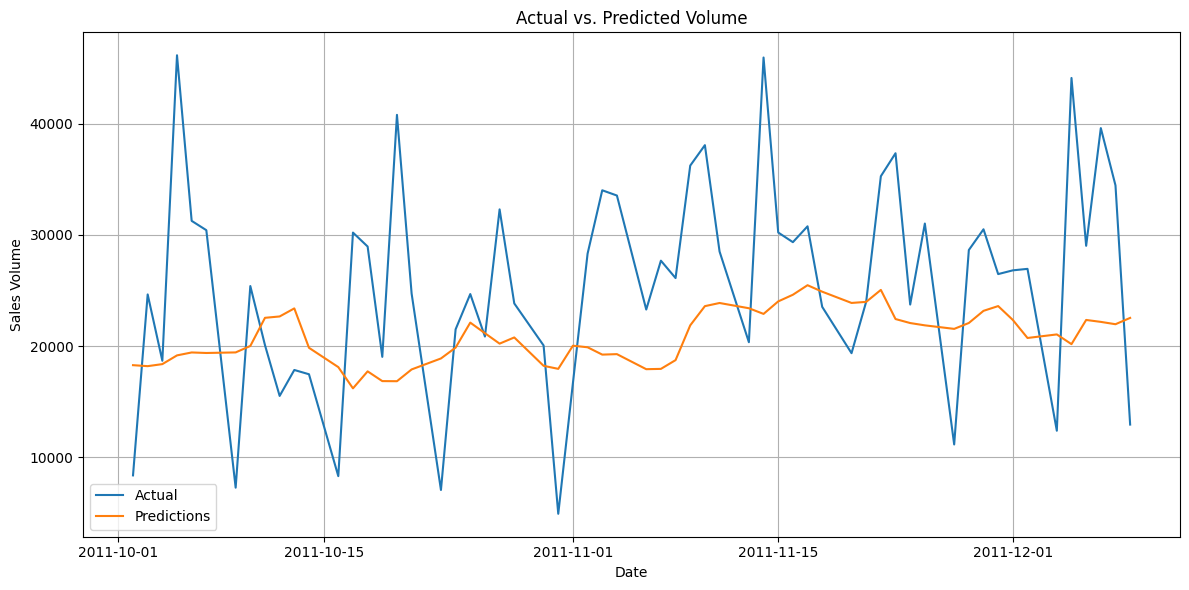

In [86]:
test_dates = daily_quantity.index[-len(y_test[0]):]  # Get dates for the test set

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Hyperparmater tuning to find optimal LSTM Model for forecasting sales volume**


*   Used the following hyperparmeters to find the optimal model with lowest RMSE

    *   Look back period - 7, 30, 90 days
    *   Number of units in model - 32,64,128,258
    *   Batch sizes - 16,32,64


*   Used nested for loops to  different models with different hyper parameters
*   After training each model, generated predictions based on test data


*   For each model calcualted the RMSE using prediction and test data
*   Captured the parameters for the model with the lowest RMSE as the "optimal model"


In [87]:
# Define a range of hyperparameters to search
units = [32, 64, 128, 256]
look_backs = [7, 30, 90]
batch_sizes = [16, 32, 64]

best_rmse_quants = float('inf')
best_params_quants = {}

In [88]:
np.random.seed(42)
tf.random.set_seed(42)
for look_back in look_backs:
  X, y = [], []
  for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])
  X, y = np.array(X), np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  y_test = scaler.inverse_transform([y_test])
  y_test = y_test.reshape(-1, 1)
  for unit in units:
    for batch_size in batch_sizes:
      model = Sequential()
      model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
      model.add(LSTM(units=unit))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')
      early_stopping = EarlyStopping(monitor='val_loss', patience=10)
      y_train = y_train.reshape(-1, 1)
      model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      predictions = model.predict(X_test)

      predictions = scaler.inverse_transform(predictions)
      rmse = np.sqrt(mean_squared_error(y_test, predictions))
      if rmse < best_rmse_quants:
        best_rmse_quants = rmse
        best_params_quants = {'units': unit, 'look_back': look_back, 'batch_size': batch_size}
        print(f'New best RMSE: {best_rmse_quants} with params: {best_params_quants}')
print("The model with best RMSE")
print(f'Best RMSE: {best_rmse_quants}')
print(f'Best Parameters: {best_params_quants}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
New best RMSE: 11057.396538488478 with params: {'units': 32, 'look_back': 7, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
New best RMSE: 10643.75666506701 with params: {'units': 32, 'look_back': 7, 'batch_size': 32}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
New best RMSE: 10568.661162131979 with params: {'units': 64, 'look_back': 7, 'batch_size': 64}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
New best RMSE: 10516.076829845773 with params: {'units': 128, 'look_back': 7, 'batch_size': 32}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
New best RMSE: 10348.673971829876 with params: {'units': 32, 'look_back': 30, 'batch_size': 16}
2/2 ━━━━━━━━━━━━━

### **LSTM Model with optimal hyperparmaterts for Sales Volume Forecasting**


*   Using the optimal hyper parameters trained the model
*   Generated predictions and obtained forecast accuracy of **64.9%**


*   Plotted the test data and predicted sales volume

In [89]:
quantity_data = daily_quantity['Quantity'].values.reshape(-1, 1)  # Reshape for scaling
scaler = MinMaxScaler()

quantity_data = scaler.fit_transform(quantity_data)

In [90]:
#Optimal Model LSTM Model for Quantity Forecast
optimal_look_back_quants = best_params_quants['look_back']
optimal_units_quants = best_params_quants['units']
optimal_batch_size_quants = best_params_quants['batch_size']
print("The optimal LSTM Model for Sales Volume Forecast")
print(f'Optimal look_back: {optimal_look_back_quants}')
print(f'Optimal units: {optimal_units_quants}')
print(f'Optimal batch_size: {optimal_batch_size_quants}')

The optimal LSTM Model for Sales Volume Forecast
Optimal look_back: 90
Optimal units: 128
Optimal batch_size: 64


In [91]:
look_back = optimal_look_back_quants  # Number of previous days to consider
X, y = [], []
for i in range(look_back, len(quantity_data)):
    X.append(quantity_data[i - look_back:i, 0])
    y.append(quantity_data[i, 0])

X, y = np.array(X), np.array(y)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Don't shuffle for time series

In [93]:
optimal_model_quants = Sequential()
optimal_model_quants.add(LSTM(units=optimal_units_quants, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Adjust units as needed
optimal_model_quants.add(LSTM(units=optimal_units_quants))  # You can add more LSTM layers
optimal_model_quants.add(Dense(1))


In [94]:
optimal_model_quants.compile(loss='mean_squared_error', optimizer='adam')

np.random.seed(42)
tf.random.set_seed(42)
optimal_model_quants.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size_quants, verbose=0)  # Adjust epochs and batch size


In [95]:
predictions = optimal_model_quants.predict(X_test)

# Inverse transform to get actual sales values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

optimal_rmse_quants = np.sqrt(mean_squared_error(y_test[0], predictions))
print(f'RMSE for optimal LSTM model for quantity forecast is  {optimal_rmse_quants}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
RMSE for optimal LSTM model for quantity forecast is  9324.901861024067


In [96]:
#mean value of sales volume in test data
print(f'Mean value of sales volume in test data is {y_test[0].mean()}')
sales_quantity_mean = y_test[0].mean()
forecasting_error= optimal_rmse_quants/sales_quantity_mean
forecasting_accuracy = 1-forecasting_error
print(f'Forecasting accuracy for quantity forecast is {forecasting_accuracy}')

Mean value of sales volume in test data is 26665.441860465115
Forecasting accuracy for quantity forecast is 0.6503001184147107


In [97]:
test_dates = daily_quantity.index[-len(y_test[0]):]

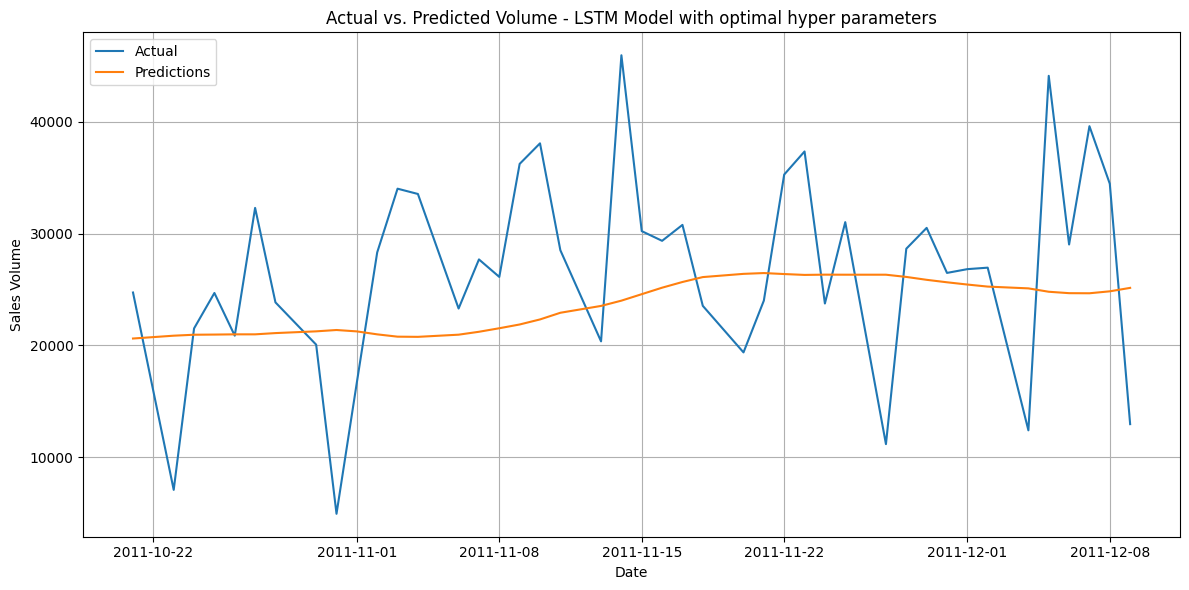

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('Actual vs. Predicted Volume - LSTM Model with optimal hyper parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Improving sales volume forecasting accuracy of LSTM model**
*  Creating a bidirectional LSTM improved forecast accuracy to **66%**
*  Adding layers to the LSMT model did not improve forecast accuracy






### **Adding additional layers to LSTM model did not improve forecasting accuracy**
*  Additional layers with the optimal hyperparemeters did not improve sales volume forecast accuracy

In [99]:
daily_quantity = online_retail_data.groupby('FullDate')['Quantity'].sum().reset_index()
daily_quantity = daily_quantity.set_index('FullDate') # Set 'FullDate' as index
quantity_data = daily_quantity['Quantity'].values.reshape(-1, 1)  # Reshape for scaling
scaler = MinMaxScaler()
quantity_data = scaler.fit_transform(quantity_data)

In [100]:
def create_quant_model(num_layers):
    model = Sequential()
    model.add(LSTM(units=optimal_units_quants, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for _ in range(num_layers - 1):
        model.add(LSTM(units=optimal_units_quants, return_sequences=True))
    model.add(LSTM(units=optimal_units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [101]:
num_layers_to_try = [1, 2, 3, 4]
best_quant_rmse = float('inf')
best_quant_layers = 0

In [102]:
np.random.seed(42)
tf.random.set_seed(42)
for num_layers in num_layers_to_try:

    model = create_quant_model(num_layers)
    X_train, X_test, y_train, y_test=set_up_data(sales_data, optimal_look_back_quants)
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)

    # Inverse transform to get actual sales values
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform([y_test])
    val_rmse = np.sqrt(mean_squared_error(y_test[0], predictions))
    print(f'RMSE for LSTM model with {num_layers} layers is  {val_rmse}')
    if val_rmse < best_quant_rmse:
        best_quant_rmse = val_rmse
        best_num_layers = num_layers

print("Best number of layers:", best_num_layers)
print("Best RMSE:", best_quant_rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
RMSE for LSTM model with 1 layers is  10413.777044343198
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
RMSE for LSTM model with 2 layers is  11731.993736448747
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
RMSE for LSTM model with 3 layers is  12494.0608221942
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
RMSE for LSTM model with 4 layers is  13797.491793397849
Best number of layers: 1
Best RMSE: 10413.777044343198


### **Creating a bidirectional LSTM model - improved forecast accuracy**
*  Bidirectional model with the optimal number of nodes, look back period and batch size improved forecast accuracy to **66%**

In [103]:

np.random.seed(42)
tf.random.set_seed(42)
X_train, X_test, y_train, y_test=set_up_data(quantity_data, optimal_look_back_quants)
bi_model_quants = Sequential()
bi_model_quants.add(Bidirectional(LSTM(units=optimal_units_quants, return_sequences=True), input_shape=(X_train.shape[1], 1)))
bi_model_quants.add(Bidirectional(LSTM(units=optimal_units_quants)))
bi_model_quants.add(Dense(1))
bi_model_quants.compile(loss='mean_squared_error', optimizer='adam')
bi_model_quants.fit(X_train, y_train, epochs=100, batch_size=optimal_batch_size, verbose=0)  # Adjust epochs and batch size
predictions_bi_model = bi_model_quants.predict(X_test)

# Inverse transform to get actual sales values
predictions_bi_model = scaler.inverse_transform(predictions_bi_model)
y_test = scaler.inverse_transform([y_test])
bi_quants_rmse = np.sqrt(mean_squared_error(y_test[0], predictions_bi_model))
print(f'RMSE for LSTM bidirectional model for sales volume with optimal hyperparameters is  {bi_quants_rmse}')
print(f'Mean value of sales volume in test data is {y_test[0].mean()}')
sales_volume_mean = y_test[0].mean()
bi_volume_error= bi_quants_rmse/sales_volume_mean
bi_volume_accuracy = 1-bi_volume_error
print(f'Forecasting sales volume accuracy for bidrectional LSTM model with optimal hyperparameters {bi_volume_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
RMSE for LSTM bidirectional model for sales volume with optimal hyperparameters is  8954.050210587155
Mean value of sales volume in test data is 26665.441860465115
Forecasting sales volume accuracy for bidrectional LSTM model with optimal hyperparameters 0.6642076940842797


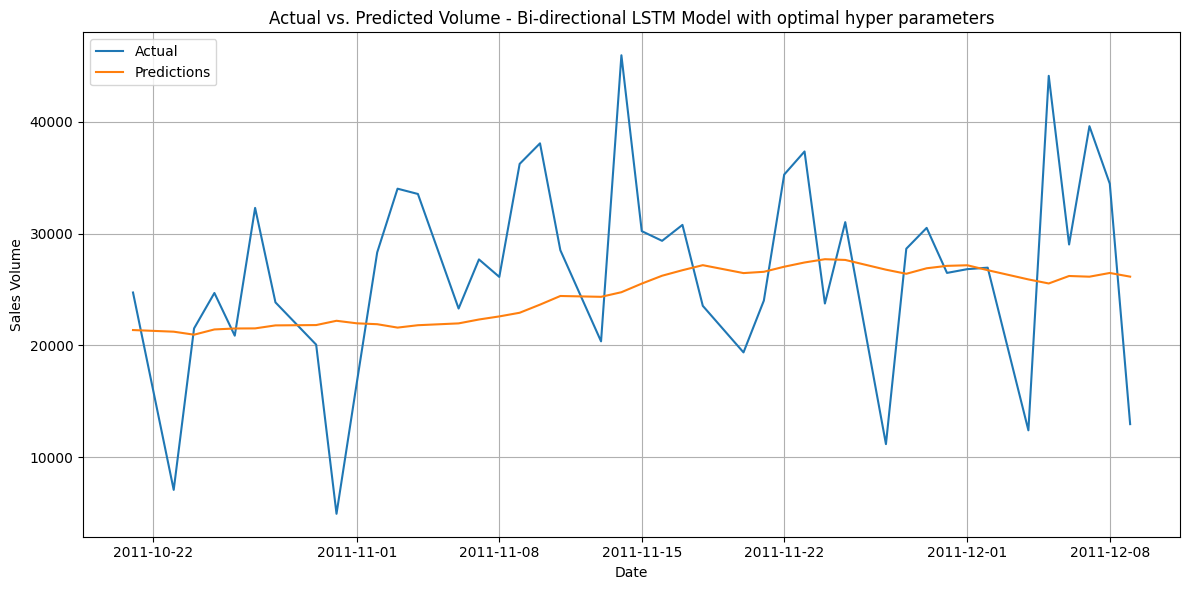

In [104]:
test_dates = daily_quantity.index[-len(y_test[0]):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test[0], label='Actual')
plt.plot(test_dates, predictions_bi_model, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('Actual vs. Predicted Volume - Bi-directional LSTM Model with optimal hyper parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
